<a href="https://colab.research.google.com/github/sergejhorvat/Tensorflow2.0_Udemy/blob/master/Creating_Image_classification_API_with_TensorFlow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stage 1: Install dependencies and setting up GPU environment

In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   9586      0 --:--:-- --:--:-- --:--:--  9617
OK


In [2]:
!apt-get update & apt-get install tensorflow-model-server

Get:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:2 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic/main amd64 Packages [31.7 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  

In [3]:
# TF 2.0 does not have great support for TF Serving yet!
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.2MB 90kB/s 
     |████████████████████████████████| 3.2MB 43.7MB/s 
     |████████████████████████████████| 368kB 49.4MB/s 
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0


In [11]:
!pip install requests

## Stage 2: Import project dependencies

In [27]:
import os
import json
import random
import requests

# Would not be realy used in this tutorial
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

# Tell matplot lib that all visualization should be kept inside of it
%matplotlib inline
tf.__version__

'1.13.1'

## Stage 3: Dataset preprocessing

### Loading the dataset

In [32]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [0]:
# Class names can be found on CIFAR10 main page https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Image normalization

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [35]:
X_train.shape

(50000, 32, 32, 3)

Check the training data if it's normalized.

In [38]:
# Take one image of size 32x32 pixels nad RGB chanells
X_train[1]

array([[[0.60392157, 0.69411765, 0.73333333],
        [0.49411765, 0.5372549 , 0.53333333],
        [0.41176471, 0.40784314, 0.37254902],
        ...,
        [0.35686275, 0.37254902, 0.27843137],
        [0.34117647, 0.35294118, 0.27843137],
        [0.30980392, 0.31764706, 0.2745098 ]],

       [[0.54901961, 0.62745098, 0.6627451 ],
        [0.56862745, 0.6       , 0.60392157],
        [0.49019608, 0.49019608, 0.4627451 ],
        ...,
        [0.37647059, 0.38823529, 0.30588235],
        [0.30196078, 0.31372549, 0.24313725],
        [0.27843137, 0.28627451, 0.23921569]],

       [[0.54901961, 0.60784314, 0.64313725],
        [0.54509804, 0.57254902, 0.58431373],
        [0.45098039, 0.45098039, 0.43921569],
        ...,
        [0.30980392, 0.32156863, 0.25098039],
        [0.26666667, 0.2745098 , 0.21568627],
        [0.2627451 , 0.27058824, 0.21568627]],

       ...,

       [[0.68627451, 0.65490196, 0.65098039],
        [0.61176471, 0.60392157, 0.62745098],
        [0.60392157, 0

## Stage 4: Defining the model

NOTE: We are using the model from the Section for Convolutional neural networks

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compiling the model

In [0]:
model.compile(optimizer='Adam',
              # sparce_* is alternative for expensive one-hot class encoding methodology
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

### Training the model

In [42]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
50000/50000 [==============================] - 12s 235us/sample - loss: 1.4936 - sparse_categorical_accuracy: 0.4618
Epoch 2/10
50000/50000 [==============================] - 11s 224us/sample - loss: 1.0313 - sparse_categorical_accuracy: 0.6411
Epoch 3/10
50000/50000 [==============================] - 11s 224us/sample - loss: 0.8498 - sparse_categorical_accuracy: 0.7055
Epoch 4/10
50000/50000 [==============================] - 11s 224us/sample - loss: 0.7179 - sparse_categorical_accuracy: 0.7492
Epoch 5/10
50000/50000 [==============================] - 11s 224us/sample - loss: 0.6262 - sparse_categorical_accuracy: 0.7820
Epoch 6/10
50000/50000 [==============================] - 11s 225us/sample - loss: 0.5468 - sparse_categorical_accuracy: 0.8106
Epoch 7/10
50000/50000 [==============================] - 11s 223us/sample - loss: 0.4723 - sparse_categorical_accuracy: 0.8350
Epoch 8/10
50000/50000 [==============================] - 11s 222us/sample - loss: 0.3982 - sparse_categ

### Model evaluation

In [43]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 167us/sample - loss: 0.8913 - sparse_categorical_accuracy: 0.7519


In [44]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.7519000172615051


## Stage 5: Saving the model for production

### Creating the directory for the model

In [0]:
MODEL_DIR = "model/"
version = 1

In [55]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [0]:
# Ensure that path of model does not exists
if os.path.isdir(export_path):
  # bash to delete it rm(remove) -r(recursevly)
    !rm -r {export_path}

### Saving the model for the TensorFlow Serving

For serving model in production additional informations are needed:


*   Input to a model
*   Outputs from model
*   Location of the model


Returns the TF session to be used by the backend:

`tf.keras.backend.get_session()` 


Path to the model:

`export_dir=export_path`



Model needs to map model parts to individual keys:

`inputs={"input_image":model.input}`


Model can have multiple outputs, we will use dictionary comprihantion method.

`outputs={t.name:t for t in model.outputs}`

In [57]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


Model directory and files have been created for serving. They can be found under files in model directory.

## Stage 6: Setting up the production environment

### Exporting the MODEL_DIR to environment variables

To serve it's needed to load the model and return inferentials.

Environmental variables need to be setup, so the path can be accessed from anywhere from system. So TFS can easili can find it.

In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Running the TensorFlow Serving REST API

`%%bash` - to enter terminal mode of system

  `-bg` run it in background
  
`nohup` - any command that follows it should be executed in the background as a service. So we can still interact with the notebook and command will kepp runin whole model structure in separate thread.

`tensorflow_model_server` - TFS application to serve the model

`--rest_api_port=8510`  - define a port for REST API serving of a model

`--model_name=cifar10`  - custom name for this model , it will be reference

`--model_base_path="${MODEL_DIR}"` - our environmental variable for model path 

`>server,log 2>&1` - create logging for the server

In [59]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 3 in a separate thread.


To see the last lines from log file use system `tail` command. It will be last 10 lines, Refresh command to update. 

In [62]:
!tail server.log

nohup: failed to run command 'tensorflow_model_server': No such file or directory


## Stage 7: Creating the first POST request

In [63]:
random_image = np.random.randint(0, len(X_test))
random_image

4924

### Creating the JSON data object

In [0]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [65]:
data

'{"signature_name": "serving_default", "instances": [[[[0.0392156862745098, 0.00784313725490196, 0.08627450980392157], [0.08627450980392157, 0.027450980392156862, 0.10196078431372549], [0.07450980392156863, 0.01568627450980392, 0.08235294117647059], [0.043137254901960784, 0.00784313725490196, 0.054901960784313725], [0.03137254901960784, 0.00784313725490196, 0.07450980392156863], [0.023529411764705882, 0.00392156862745098, 0.0784313725490196], [0.03137254901960784, 0.00784313725490196, 0.07058823529411765], [0.03137254901960784, 0.011764705882352941, 0.06274509803921569], [0.027450980392156862, 0.00784313725490196, 0.054901960784313725], [0.01568627450980392, 0.00784313725490196, 0.054901960784313725], [0.01568627450980392, 0.00392156862745098, 0.058823529411764705], [0.043137254901960784, 0.00784313725490196, 0.07450980392156863], [0.12549019607843137, 0.058823529411764705, 0.13725490196078433], [0.11372549019607843, 0.027450980392156862, 0.10980392156862745], [0.050980392156862744, 0.

### Sending the first POST request to the model

In [0]:
headers = {"content-type":"application/json"}

In [0]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers=headers)

In [0]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [0]:
predictions

[[1.43151e-05,
  8.25434e-09,
  0.00420625,
  0.0147217,
  0.0125217,
  0.00353992,
  0.000103995,
  0.964891,
  1.08745e-06,
  5.2131e-09]]

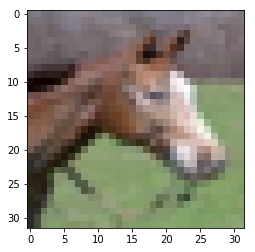

In [0]:
plt.imshow(X_test[random_image])

In [0]:
class_names[np.argmax(predictions[0])]

'horse'

## Stage 8: Sending the POST request to a specific model

In [0]:
specific_json_response = requests.post(url="http://localhost:8501/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [0]:
specific_json_response

<Response [200]>